# Setup

In [162]:
import numpy as np
from pandas import DataFrame
import matplotlib
import matplotlib.pyplot as plt

In [163]:
fig_height = 3.5

In [164]:
# error dict
error_labels = {
    "Cannot find name 'clone'. Did you mean 'close'?" : "Cannot find name (suggestion).",
    "Cannot find name 'One'. Did you mean 'one'?": "Cannot find name (suggestion).",
    "Cannot use JSX unless the '--jsx' flag is provided." : "JSX",
    "Left side of comma operator is unused and has no side effects." : "Left side comma operator unused",
    "Type annotations can only be used in TypeScript files." : "Type annotations",
    "A 'return' statement can only be used within a function body.": "Return outside function",
    "Property 'setState' does not exist on type 'UnicornEditor'.": "Property doesn't exist on type",
    "Top-level 'await' expressions are only allowed when the 'module' option is set to 'es2022' 'esnext' 'system' 'node16' or 'nodenext' and the 'target' option is set to 'es2017' or higher.": "Top level await",
    "Cannot find name 'it'. Do you need to install type definitions for a test runner? Try `npm i --save-dev @types/jest` or `npm i --save-dev @types/mocha` and then add 'jest' or 'mocha' to the types field in your tsconfig.": "Cannot find name (it).",
    "Parsing error: Unexpected token": "Parsing.unexpectedToken",
    "Parsing error: 'import' and 'export' may appear only with 'sourceType: module'": "Parsing.importExport",
    "Parsing error: Unexpected character": "Parsing.unexpectedCharacter",
    "Parsing error: Identifier has already been declared": "Parsing.alreadyDeclared",
    "Parsing error: Invalid regular expression" : "Parsing.invalidRegEx",
    "Parsing error: Assigning to rvalue": "Parsing.assignedToRvalue",
    "Parsing error: Unterminated regular expression": "Parsing.unterminatedRegEx",
    "Parsing error: Identifier directly after number": "Parsing.identifierAfterNumber",
    "Parsing error: Unterminated string constant": "Parsing.unterminatedStringConstant",
    "Parsing error: Expecting Unicode escape sequence \\uXXXX":  "Parsing.expectedUnicodeEscape",
}

def getLabels(errors):
    errors = list(errors)
    for i, e in enumerate(errors):
        if e in error_labels:
            e = error_labels[e]
        else:
            if e.endswith("."):
                e = e[:-1]
        errors[i] = e
    return errors

def overview(e):
    print("Total Snippets: " + str(e.snippets))
    print("Snippets with no Errors: " + str(e.noErrors) + "/" + str(e.snippets) + "(" + str(e.noErrors/e.snippets) + ")")
    print("Snippets with Errors: " + str(e.snippets-e.noErrors) + "/" + str(e.snippets) + "(" + str(1 - e.noErrors/e.snippets) + ")")

In [165]:
# figures
def top10Errors(df, column, label="Occurances (million)", title="Common Error Types", saveas='commonErrorTypes', getLabels=getLabels, xlim=8000000, format=lambda x, p: format(int(x/1000000), ',')):
    top10_df = df.nlargest(10, [column]).iloc[::-1]

    fig, ax = plt.subplots()
    fig.set_size_inches(4, fig_height)
    ax1 = ax.barh(getLabels(top10_df["ERROR"]), top10_df[column], color="black")
    ax.set_xlabel(label)
    ax.set_ylabel("Errors")
    ax.set_xlim(0, xlim)
    if format:
        ax.get_xaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(format))
    ax.tick_params(axis='both', which='major', labelsize=8.5)
    ax.set_title(title)

    labels = []
    for n in top10_df[column]:
        if(n>1000000):
            n = str(round(n/1000000, 1)) + "m"
        else:
            n = int(n)
        labels.append(n)
    ax.bar_label(ax1, label_type='edge', labels=labels, padding=1, size=8)
    plt.savefig(saveas, bbox_inches = "tight")
    plt.show()

In [166]:
#classes
class Log:

    def __init__(self, filename, heading = "ERROR, CODE, CATEGORY, NUM OCCURANCES, NUM AFFECTED SNIPPETS, FIRST ID, PERCENT"):
        rows = []
        self.snippets = None
        self.noErrors = None

        if isinstance(filename, str):
            file = open(filename, encoding="utf8")
            lines = file.readlines()
        else:
            lines = filename

        headings = []
        csv_mode = False
        for line in lines:
            line = line.strip()
            if line.startswith(heading):
                csv_mode = True
                headings = line.split(",")
                headings = [h.strip() for h in headings]
                continue
            if(csv_mode):
                if not line:
                    csv_mode = False
                    continue
                parts = line.split(",")
                to = len(headings)-1
                columns = ["".join(parts[0:-to])]
                for p in parts[-to:]:
                    p = p.strip()
                    if p == "true":
                        p = True
                    elif p == "undefined":
                        p = False
                    elif p == "":
                        p = None
                    else:
                        p = float(p)
                    columns.append(p)
                # columns += [float(p.strip()) for p in parts[-to:]]
                rows.append(columns)
                continue
            if line.startswith("Snippets without errors"):
                self.noErrors = int(line.split(":")[1].split("/")[0])
            if line.startswith("TOTAL SNIPPETS:"):
                self.snippets = int(line.split(":")[1].strip())
        
        self.errors = DataFrame.from_records(rows, columns=headings)

    def getLines(filename, heading, end):
        file = open(filename, encoding="utf8")
        lines = file.readlines()
        record = True
        newLines = []
        for line in lines:
            if line.startswith("--------"):
                record = False
            if line.startswith(heading):
                record = True
            if end and line.startswith(end):
                reocrd = False
            if record:
                newLines.append(line)
        return newLines
    

In [167]:
#load files
DATA_DIR = "../data";
ESLINT_DIR = DATA_DIR + "/eslintErrors.log"
SAMPLE_DIR = DATA_DIR + "/384-sample.log"
ERRORS_DIR = DATA_DIR + "/finalErrors.log"
DELETION_DIR = DATA_DIR + "/afterDeletion.log"

errors = Log(ERRORS_DIR)
deletion = Log(DELETION_DIR)

eslint_heading = "ERROR, SEVERITY, FATAL, NUM OCCURANCES, NUM AFFECTED SNIPPETS, PERCENT"

eslint_p_errors = Log(Log.getLines(ESLINT_DIR, "PARSING ERROR ANALYSIS", "RULE ANALYSIS"), eslint_heading)
eslint_errors = Log(Log.getLines(ESLINT_DIR, "RULE ANALYSIS", "ESLINT FIX ANALYSIS"), eslint_heading)
eslint_allfixes = Log(Log.getLines(ESLINT_DIR, "ALL FIXES", None), eslint_heading)


# Eslint

## Parsing Error Analysis

ESLint with parsing errors enabled only.

### Overview

In [168]:
p_errors_df = eslint_p_errors.errors
overview(eslint_p_errors)

Total Snippets: 2161911
Snippets with no Errors: 1192529/2161911(0.5516087387501151)
Snippets with Errors: 969382/2161911(0.44839126124988493)


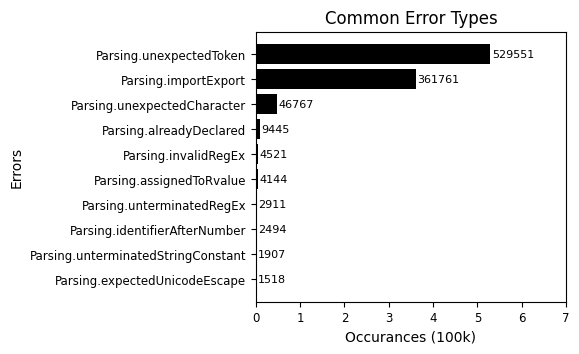

In [169]:
top10Errors(p_errors_df, "NUM OCCURANCES", saveas="eslint-commonErrorTypesParsing", xlim=700000, 
    format = lambda x, p: format(int(x/100000), ','), label="Occurances (100k)")

## Error Analysis

ESLint with rules enabled, and warnings filtered out for these results.

Warnings don't impact code runnability, some exist just to enable formatting fixes in NCQ.

Results are the same as only parsing errors for the top 10.

In [170]:
errors_df = eslint_errors.errors
errors_df = errors_df[errors_df["SEVERITY"] == 2]
overview(eslint_errors)

Total Snippets: 2161911
Snippets with no Errors: 318498/2161911(0.147322438342744)
Snippets with Errors: 1843413/2161911(0.852677561657256)


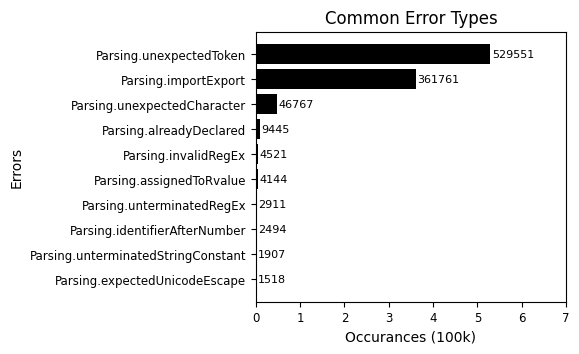

In [171]:
top10Errors(errors_df, "NUM OCCURANCES", saveas="eslint-commonErrorTypes", xlim=700000,
    format = lambda x, p: format(int(x/100000), ','), label="Occurances (100k)")

## All Fixes

In [172]:
af_errors_df = eslint_allfixes.errors
overview(eslint_allfixes)

Total Snippets: 2161911
Snippets with no Errors: 2021652/2161911(0.9351226761878727)
Snippets with Errors: 140259/2161911(0.0648773238121273)


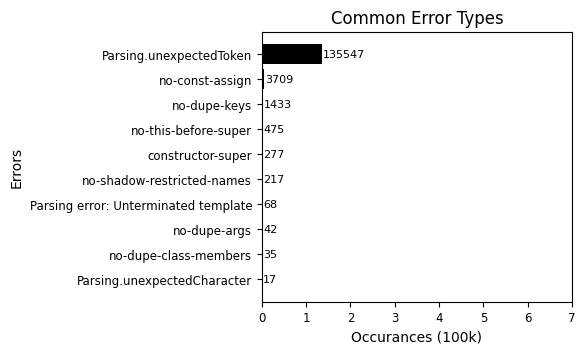

In [173]:
top10Errors(af_errors_df, "NUM OCCURANCES", saveas="eslint-commonErrorTypesDeletion", xlim=700000,
    format = lambda x, p: format(int(x/100000), ','), label="Occurances (100k)")


# TypeScript

## Error Analysis

### Overview

In [174]:
errors_df = errors.errors
print("Total Snippets: " + str(errors.snippets))
print("Snippets with no Errors: " + str(errors.noErrors) + "/" + str(errors.snippets) + "(" + str(errors.noErrors/errors.snippets) + ")")
print("Snippets with Errors: " + str(errors.snippets-errors.noErrors) + "/" + str(errors.snippets) + "(" + str(1 - errors.noErrors/errors.snippets) + ")")
#there is only one snippet with a non-1 category?
print(list(errors_df[errors_df["CATEGORY"] != 1.0]["ERROR"]))
print(list(errors_df[errors_df["CATEGORY"] != 1.0]["FIRST ID"]))

Total Snippets: 2161911
Snippets with no Errors: 584787/2161911(0.270495408922939)
Snippets with Errors: 1577124/2161911(0.729504591077061)
['Dynamic imports can only accept a module specifier and an optional assertion as arguments']
[241928.0]


### Most common errors (occurances)

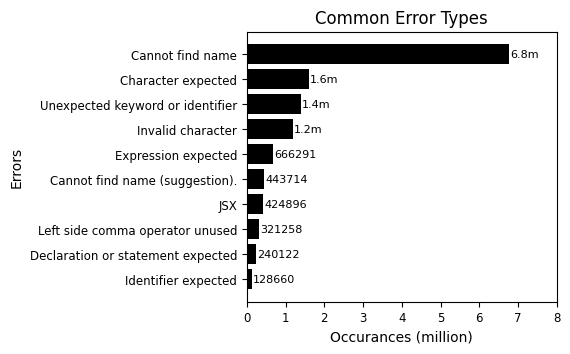

In [175]:
errors_df = errors.errors
top10Errors(errors_df, "NUM OCCURANCES", saveas="commonErrorTypes")


### Most common errors (snippets affected)

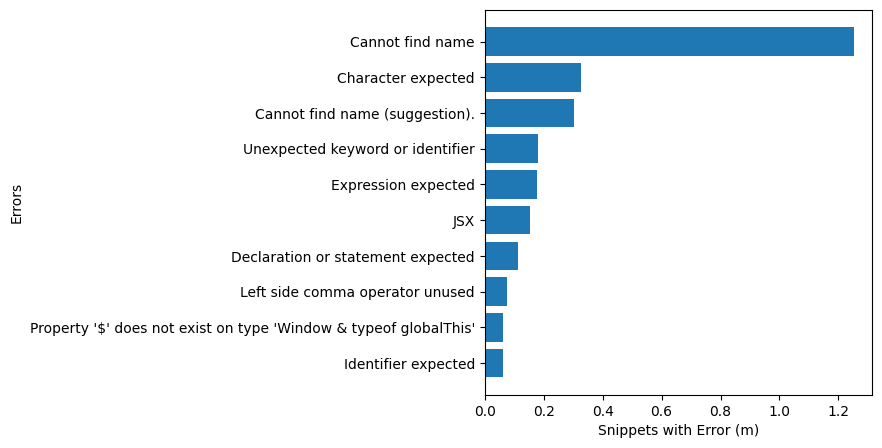

In [176]:
top10_df = errors_df.nlargest(10, ['NUM AFFECTED SNIPPETS']).iloc[::-1]

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax.barh(getLabels(top10_df["ERROR"]), top10_df["NUM AFFECTED SNIPPETS"])
ax.set_xlabel("Snippets with Error (m)")
ax.set_ylabel("Errors")
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(x/1000000, ',')))

## Post Deletion Analysis

### Overview

In [177]:
deletion_df = deletion.errors
print("Total Snippets: " + str(deletion.snippets))
print("Snippets with no Errors: " + str(deletion.noErrors) + "/" + str(deletion.snippets) + "(" + str(deletion.noErrors/deletion.snippets) + ")")
print("Snippets with Errors: " + str(deletion.snippets-deletion.noErrors) + "/" + str(deletion.snippets) + "(" + str(1 - deletion.noErrors/deletion.snippets) + ")")
#there is only one snippet with a non-1 category?
print(list(deletion_df[deletion_df["CATEGORY"] != 1.0]["ERROR"]))
print(list(deletion_df[deletion_df["CATEGORY"] != 1.0]["FIRST ID"]))

Total Snippets: 2161911
Snippets with no Errors: 1591310/2161911(0.7360663783106706)
Snippets with Errors: 570601/2161911(0.26393362168932943)
['Dynamic imports can only accept a module specifier and an optional assertion as arguments']
[11083.0]


### Most common errors (occurances)

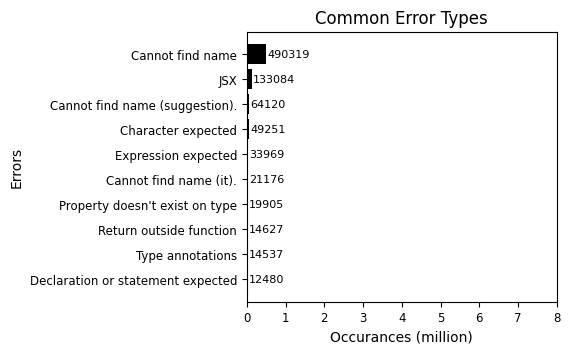

In [178]:
top10Errors(deletion_df, "NUM OCCURANCES", saveas="commonErrorTypesDeletion")


### Most common errors (snippets affected)

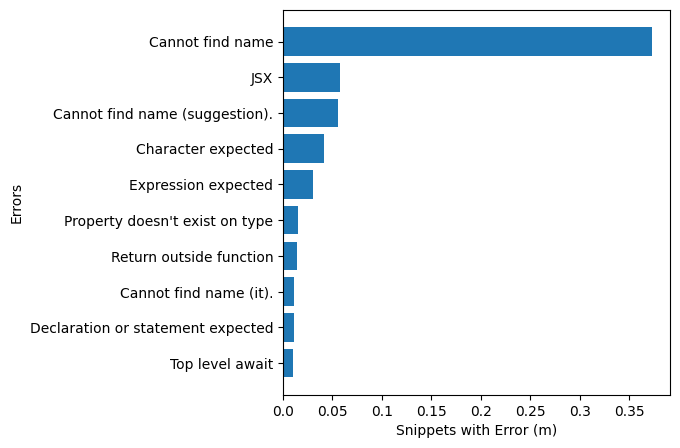

In [179]:
top10_df = deletion_df.nlargest(10, ['NUM AFFECTED SNIPPETS']).iloc[::-1]

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax.barh(getLabels(top10_df["ERROR"]), top10_df["NUM AFFECTED SNIPPETS"])
ax.set_xlabel("Snippets with Error (m)")
ax.set_ylabel("Errors")
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(x/1000000, ',')))